<a href="https://colab.research.google.com/github/mohitraosatya/infleqtion-poc/blob/main/Infleqtion_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install gym if not already installed
!pip install gym

# For our RL implementation and plotting:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [2]:
class QuantumCircuitDecompositionEnv(gym.Env):
    """
    A custom Gym environment simulating quantum circuit decomposition.
    The circuit consists of a fixed number of gates.
    For each gate, the agent chooses a decomposition:
      - Action 0: optimal decomposition (cost = 2)
      - Action 1: suboptimal decomposition (cost = 4)
    The goal is to minimize the total cost (i.e. maximize the negative cost reward).
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, num_gates=5):
        super(QuantumCircuitDecompositionEnv, self).__init__()
        self.num_gates = num_gates  # total number of gates in the circuit
        self.current_gate = 0       # index of the current gate
        self.total_cost = 0         # accumulated cost

        # Define action space: 0 or 1 (2 discrete actions)
        self.action_space = spaces.Discrete(2)

        # Define observation space: simply the current gate index (from 0 to num_gates)
        self.observation_space = spaces.Discrete(self.num_gates + 1)

    def reset(self):
        self.current_gate = 0
        self.total_cost = 0
        return self.current_gate  # initial observation

    def step(self, action):
        # Validate action
        if action not in [0, 1]:
            raise ValueError("Invalid action! Must be 0 or 1.")

        # Define cost based on action
        if action == 0:
            cost = 2  # optimal decomposition
        else:
            cost = 4  # suboptimal decomposition

        self.total_cost += cost

        # Move to next gate
        self.current_gate += 1

        # Check if episode is done
        done = self.current_gate >= self.num_gates

        # We use negative cost as reward (we want to minimize cost)
        reward = -cost

        return self.current_gate, reward, done, {}

    def render(self, mode='human'):
        print(f"Gate {self.current_gate}/{self.num_gates}, Total Cost: {self.total_cost}")

    def close(self):
        pass

# Test the environment quickly:
env = QuantumCircuitDecompositionEnv(num_gates=5)
obs = env.reset()
print("Initial state:", obs)
for _ in range(5):
    obs, reward, done, _ = env.step(0)  # always choose the optimal action (0)
    env.render()

Initial state: 0
Gate 1/5, Total Cost: 2
Gate 2/5, Total Cost: 4
Gate 3/5, Total Cost: 6
Gate 4/5, Total Cost: 8
Gate 5/5, Total Cost: 10


In [3]:
# Define Q-learning parameters
num_episodes = 5000
alpha = 0.1         # learning rate
gamma = 0.95        # discount factor
epsilon = 1.0       # exploration rate (start high)
min_epsilon = 0.01
decay_rate = 0.001

# Initialize Q-table: rows = states (0 to num_gates), columns = actions (0 and 1)
num_states = env.observation_space.n
num_actions = env.action_space.n
Q_table = np.zeros((num_states, num_actions))

# Store total rewards per episode for plotting
rewards_all_episodes = []

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_rewards = 0

    while not done:
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # explore
        else:
            action = np.argmax(Q_table[state])  # exploit learned values

        new_state, reward, done, _ = env.step(action)
        total_rewards += reward

        # Q-learning update rule
        Q_table[state, action] = Q_table[state, action] + alpha * (
            reward + gamma * np.max(Q_table[new_state]) - Q_table[state, action]
        )

        state = new_state

    # Decay epsilon after each episode
    epsilon = max(min_epsilon, epsilon * np.exp(-decay_rate * episode))
    rewards_all_episodes.append(total_rewards)

# Print the learned Q-table
print("Learned Q-table:")
print(Q_table)

Learned Q-table:
[[ -9.0487625  -10.74750456]
 [ -7.41975     -9.33777308]
 [ -5.705       -7.63908786]
 [ -3.9         -5.73285228]
 [ -2.          -3.96508815]
 [  0.           0.        ]]


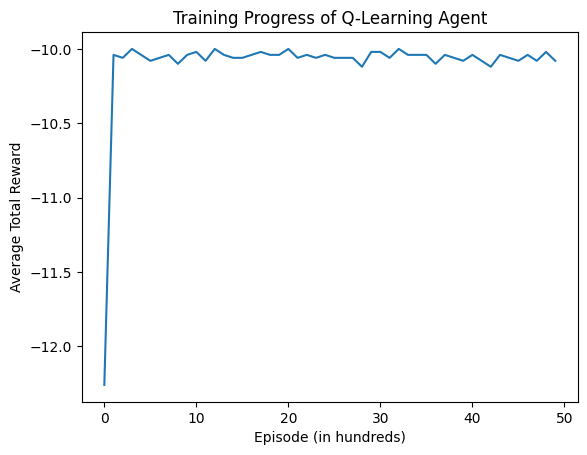

In [4]:
# Compute average reward per 100 episodes
avg_rewards = np.split(np.array(rewards_all_episodes), num_episodes/100)
avg_rewards = [np.mean(segment) for segment in avg_rewards]

plt.plot(avg_rewards)
plt.xlabel("Episode (in hundreds)")
plt.ylabel("Average Total Reward")
plt.title("Training Progress of Q-Learning Agent")
plt.show()

In [5]:
state = env.reset()
done = False
actions_taken = []
while not done:
    action = np.argmax(Q_table[state])
    actions_taken.append(action)
    state, reward, done, _ = env.step(action)
    env.render()

# Calculate total cost based on actions
# (Recall: action 0 cost = 2, action 1 cost = 4)
total_cost = sum(2 if a == 0 else 4 for a in actions_taken)
print("\nActions taken:", actions_taken)
print("Expected total cost (should be minimal):", total_cost)

Gate 1/5, Total Cost: 2
Gate 2/5, Total Cost: 4
Gate 3/5, Total Cost: 6
Gate 4/5, Total Cost: 8
Gate 5/5, Total Cost: 10

Actions taken: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Expected total cost (should be minimal): 10
